In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from algos import *

In [36]:
def create_adjacency_matrix_from_links(num_nodes, links):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for link in links:
        from_node, to_node = link
        # adjacency_matrix[from_node, to_node] = 1
        adjacency_matrix[to_node, from_node] = 1

    return adjacency_matrix


def init_env():
    links = [
        (0, 2),
        (0, 4),
        (0, 5),
        (0, 6),
        (1, 3),
        (1, 8),
        (2, 0),
        (2, 1),
        (3, 0),
        (4, 0),
        (4, 5),
        (5, 4),
        (5, 10),
        (6, 4),
        (6, 9),
        (6, 11),
        (7, 5),
        (7, 8),
        (8, 1),
        (8, 5),
        (9, 6),
        (9, 12),
        (10, 5),
        (10, 7),
        (10, 13),
        (11, 5),
        (11, 6),
        (11, 7),
        (11, 14),
        (12, 8),
        (13, 5),
        (13, 11),
        (14, 5),
        (14, 11),
    ]

    num_nodes = 15
    connectivity_matrix = create_adjacency_matrix_from_links(num_nodes, links)
    # connectivity_matrix = normalize_adjacency_matrix(connectivity_matrix)

    initial_opinions = np.linspace(0, 1, num_nodes)

    env = NetworkGraph(
        connectivity_matrix=connectivity_matrix,
        initial_opinions=initial_opinions,
        max_u=0.2,
        budget=100.0,
        desired_opinion=1.0,
        tau=0.5,
        max_steps=1_000_000,
    )

    env.reset()

    return env

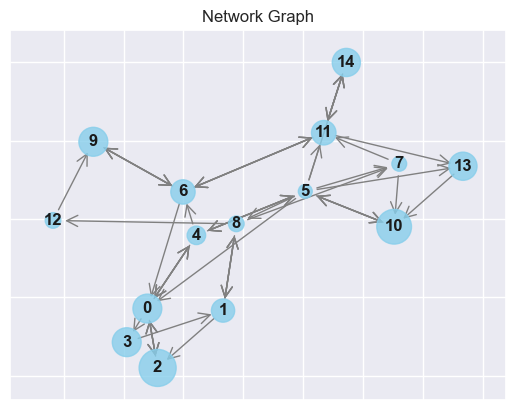

In [37]:
env = init_env()
env.render(mode="matplotlib")

c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


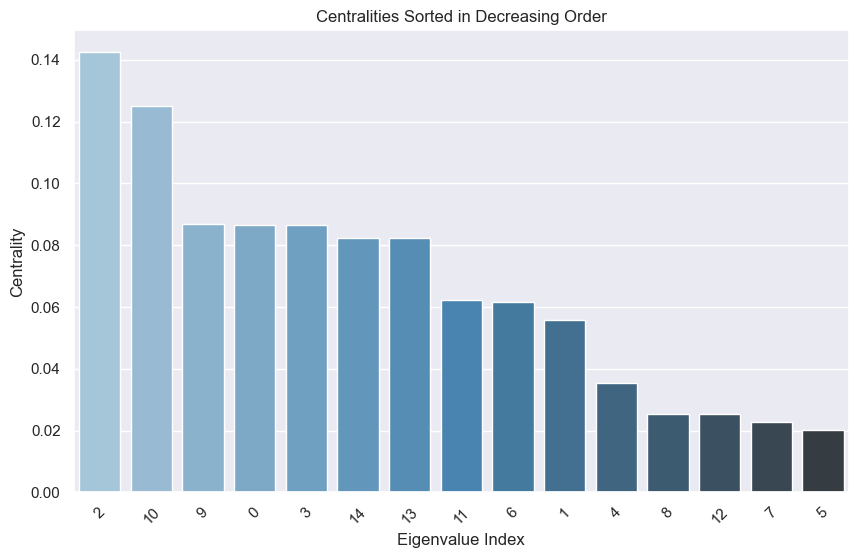

In [38]:
env.render(mode="centralities")

## Zero control 

Overall Error: 0.5079612001655786
Final Error: 0.5134870962840572


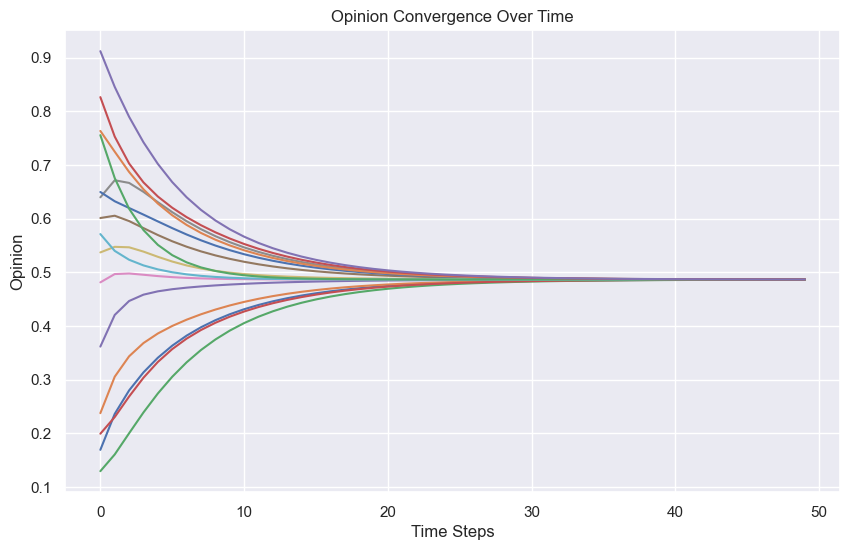

In [39]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 50

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    no_action_u = np.zeros(env.num_agents)  # Zero control input
    opinions, reward, done, truncated, info = env.step(no_action_u)
    opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

## Broadcast Strategy (use all available budget at start)

[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
Broadcast Strategy - Overall Error: 0.4081531665919183
Final Error: 0.4107871997906066


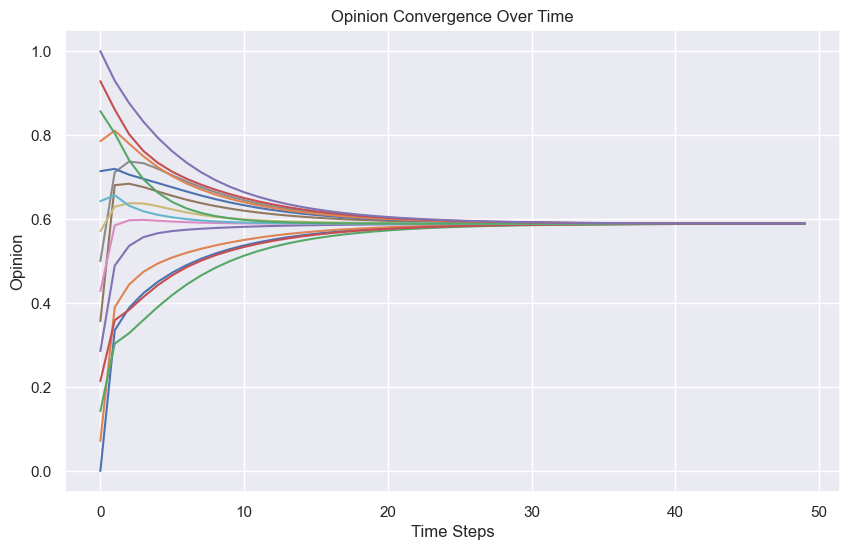

In [40]:
env = init_env()
num_steps = 50  # Total number of steps in the simulation
Q = 15  # Total budget

# Run the experiment with the broadcast strategy
opinions_over_time_broadcast, budget_distribution, affected_nodes = (
    run_broadcast_strategy(env, Q, num_steps)
)
overall_error_broadcast = compute_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)
final_error_broadcast = compute_final_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time_broadcast)

### Broadcast with single step

[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
Broadcast Strategy - Overall Error: 0.45539483851362295
Final Error: 0.4107896770272456


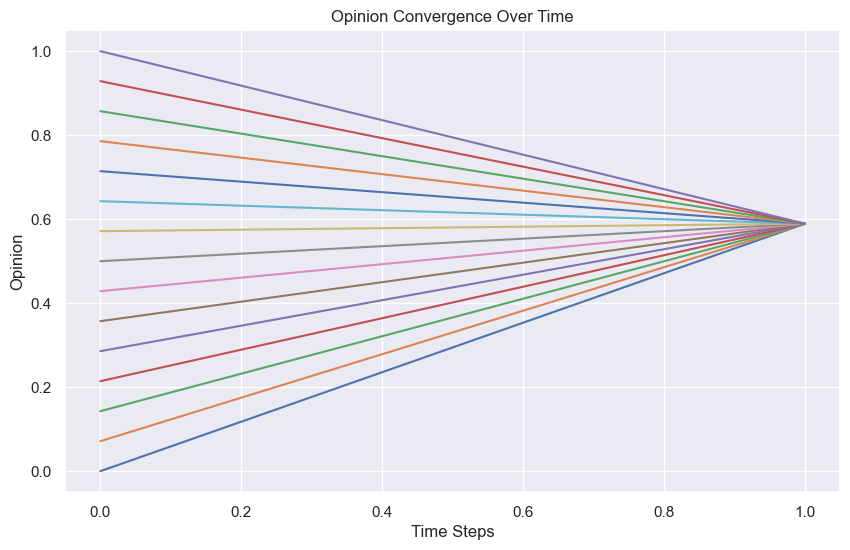

In [41]:
env = init_env()
num_steps = 50  # Total number of steps in the simulation
Q = 15  # Total budget

opinions_over_time = np.zeros((2, env.num_agents))

# Lists to store budget distribution and affected nodes
budget_distribution = []
affected_nodes = []

# Store opinions before applying the first control step
opinions_over_time[0] = env.opinions.copy()

# Calculate the control action using the total budget (units of u_max)
optimal_action, remaining_budget = optimal_control_action(env, Q)
print(optimal_action)

# Apply the control for the first step
opinions, reward, done, truncated, info = env.step(
    optimal_action, action_duration=0.5, step_duration=0.5 * num_steps
)
opinions_over_time[1] = opinions

# Track affected nodes and budget
affected_nodes.append(list(np.where(optimal_action > 0)[0]))
budget_distribution.append(np.sum(optimal_action))  # Budget used in the first step

overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

Broadcast Strategy with Sampling - Overall Error: 0.40820486287496394
Final Error: 0.4107896770272463


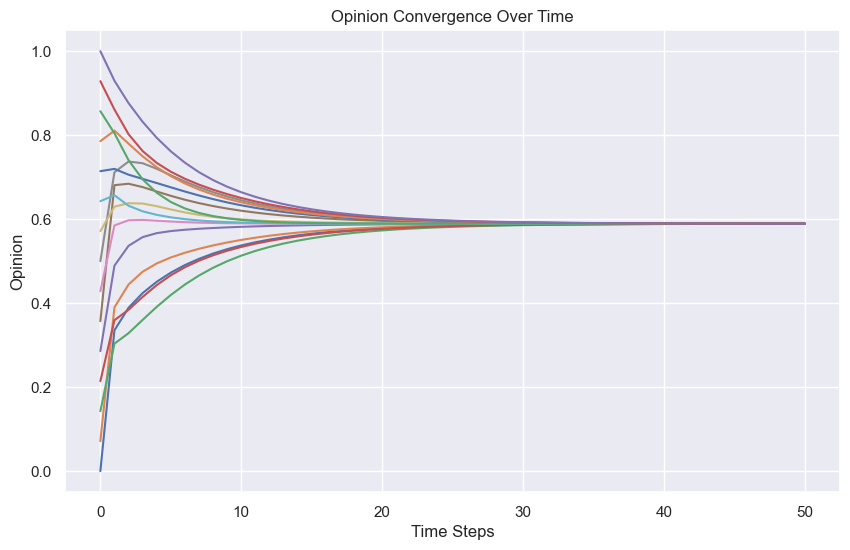

In [46]:
env = init_env()
num_steps = 50  # Total number of steps in the simulation

# Parameters
Q = 15  # Total budget (units of max_u)
action_duration = 0.5  # Duration over which the action is applied
step_duration = 0.5 * num_steps  # Total duration over multiple steps
sampling_time = 0.5  # Sampling interval (same as action_duration for simplicity)


# Determine the control action using the total budget (units of max_u)
optimal_action, remaining_budget = optimal_control_action(env, Q)

# Run the campaign with sampling
opinions_over_time, time_points = run_campaign_with_sampling(
    env,
    action=optimal_action,
    action_duration=action_duration,
    step_duration=step_duration,
    sampling_time=sampling_time,
)

# Compute errors
overall_error = compute_average_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

print(f"Broadcast Strategy with Sampling - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")
plot_opinions_over_time(opinions_over_time)

### Short campaigns

In [51]:
from algos import dynamic_programming_strategy

env = init_env()
M = 4
Q = 15
num_steps = 2  # Total number of steps in the simulation
action_duration = 0.5
step_duration = 0.5 * num_steps  # Total duration over multiple steps

optimal_budget_allocation = dynamic_programming_strategy(
    env, M, Q, action_duration, step_duration
)
optimal_budget_allocation

Processing campaign 3
Processing campaign 2
Processing campaign 1
Processing campaign 0


[6, 7, 0, 2]

Running campaign 1/4
Running campaign 2/4
Running campaign 3/4
Running campaign 4/4
Dynamic Programming Strategy - Overall Error: 0.3502505454595248
Final Error: 0.3443224244934662


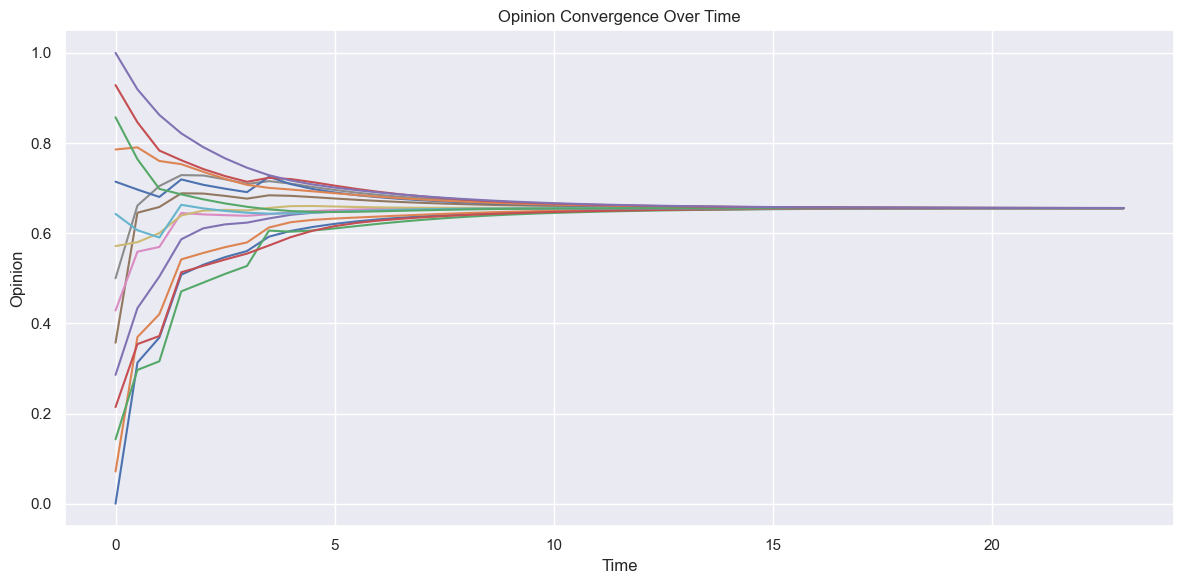

In [62]:
from algos import run_dynamic_programming_campaigns

env = init_env()

sampling_time = 0.5 
final_campaign_step_duration = 20.0  # Longer duration for the final campaign
final_campaign_sampling_time = 0.5

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp = run_dynamic_programming_campaigns(
    env,
    optimal_budget_allocation,
    action_duration,
    step_duration,
    sampling_time,
    final_campaign_step_duration=final_campaign_step_duration,
    final_campaign_sampling_time=final_campaign_sampling_time,
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

plot_opinions_over_time(opinions_over_time_dp, time_points_dp)

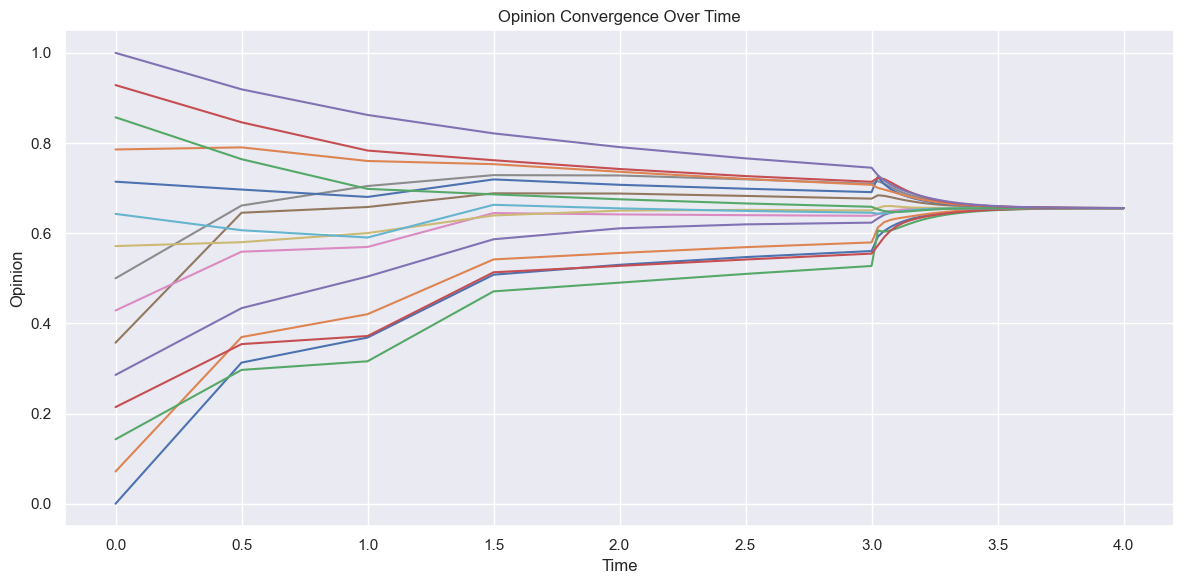

In [64]:
from algos import normalize_campaign_time


# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]

normalized_time_points_dp = normalize_campaign_time(time_points_dp, campaign_durations, step_duration, final_campaign_step_duration)

# Plot the opinions over time using the normalized time points
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

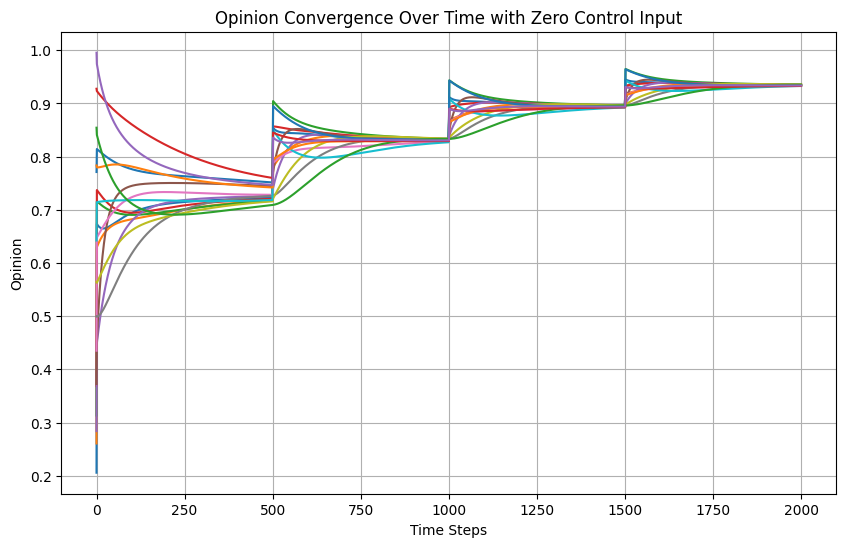

In [ ]:
env = init_env()

# Define the number of steps for which to apply the zero control input
num_steps = 2000
k = 500  # Apply optimal control every k steps
N = 5  # Number of consecutive steps to apply optimal control
budget = 1  # Example budget

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation
for i in range(num_steps):
    if i % k == 0:
        # Apply the optimal control every k steps for N consecutive steps
        for j in range(N):
            if i + j < num_steps:
                optimal_u = optimal_control_action(env, budget=budget)
                # print(f"Applying optimal control at step {i + j}: {optimal_u}")
                opinions, reward, done, truncated, info = env.step(optimal_u)
                opinions_over_time[i + j] = opinions
        # Skip the next N-1 steps as they are already processed
        i += N - 1
    else:
        # Apply zero control input at other steps
        optimal_u = np.zeros(env.num_agents)
        opinions, reward, done, truncated, info = env.step(optimal_u)
        opinions_over_time[i] = opinions

# Plot the collected opinions over time
plot_opinions_over_time(opinions_over_time)

In [ ]:
env = init_env()
M = 3  # Number of campaigns
Q = 15  # Total budget

optimal_budget_allocation = brute_force_strategy(env, M, Q)
print("Optimal budget allocation:", optimal_budget_allocation)

Optimal budget allocation: [3 3 3 3]


In [ ]:
env = init_env()

# Example usage with the environment
M = 5  # Number of campaigns
Q = 20  # Total budget

optimal_budget_allocation = dynamic_programming_strategy(env, M, Q)
print("Optimal budget allocation for each campaign:", optimal_budget_allocation)

Optimal budget allocation for each campaign: [4 3 3 3 3 4]


Optimal budget allocation (brute_force): [3 3 3 3]
Brute Force Strategy - Overall Error: 6.104991006235625
Final Error: 3.3306690738754696e-15


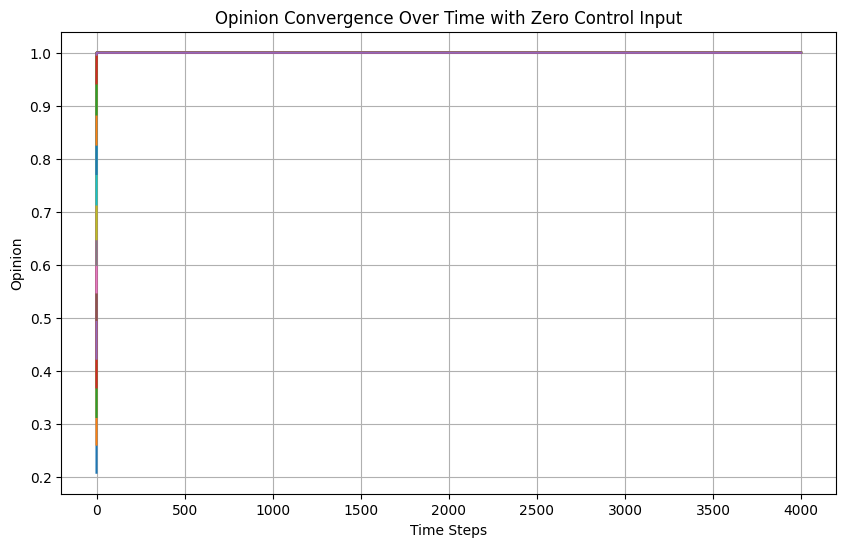

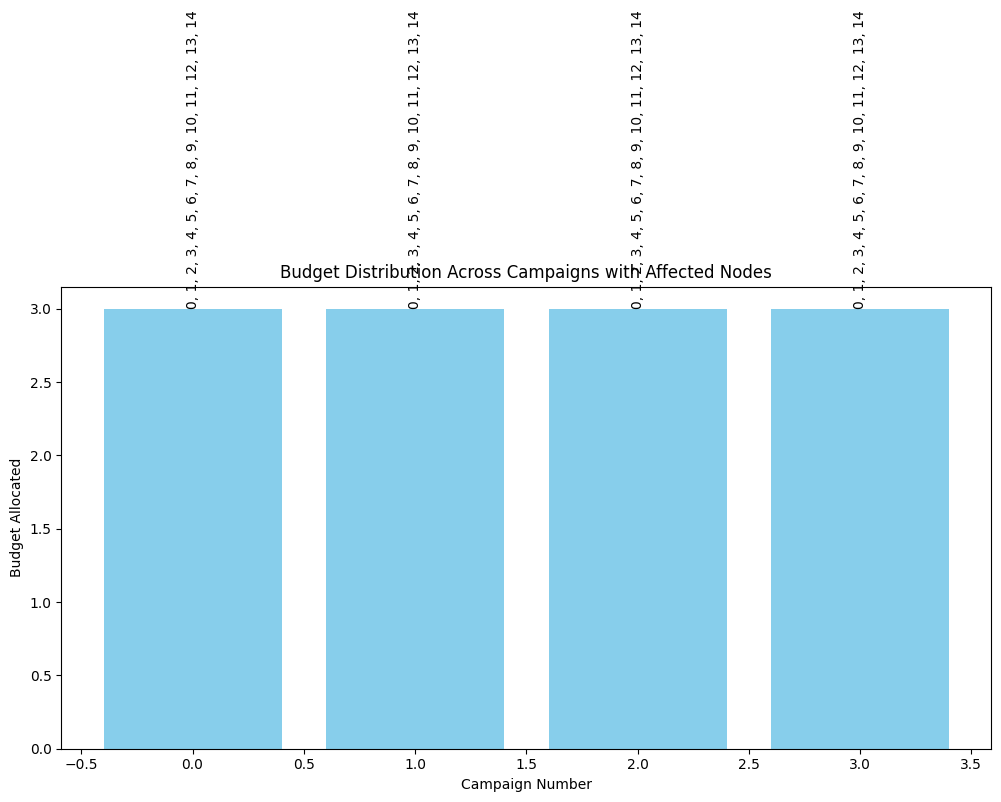

In [ ]:
# Example usage
env = init_env()
num_steps = 4000  # Total number of steps in the simulation
M = 3  # Number of campaigns
Q = 15  # Total budget
campaign_length = 0.5  # Time step

# Run the experiment with brute force strategy
opinions_over_time, budget_distribution, affected_nodes = run_experiment(
    env,
    num_steps,
    M,
    Q,
    env.tau,
    strategy="brute_force",
    campaign_length=campaign_length,
)

# Compute errors
overall_error = compute_average_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

print(f"Brute Force Strategy - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")

# Plot opinions over time
plot_opinions_over_time(opinions_over_time)

# Plot budget distribution and affected nodes
plot_budget_distribution(budget_distribution, affected_nodes)

Optimal budget allocation (brute_force): [3 3 3 3]
Brute Force Strategy - Overall Error: 18280.515590749153
Final Error: 3.168549164594347


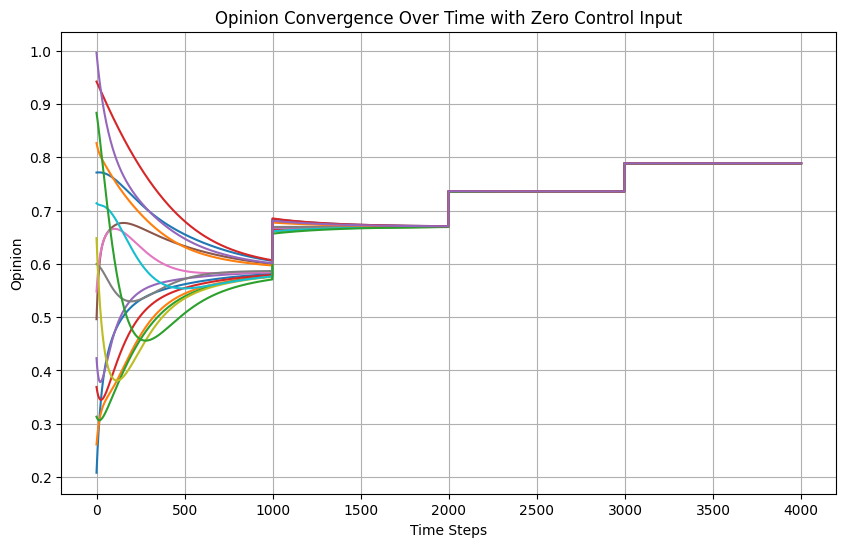

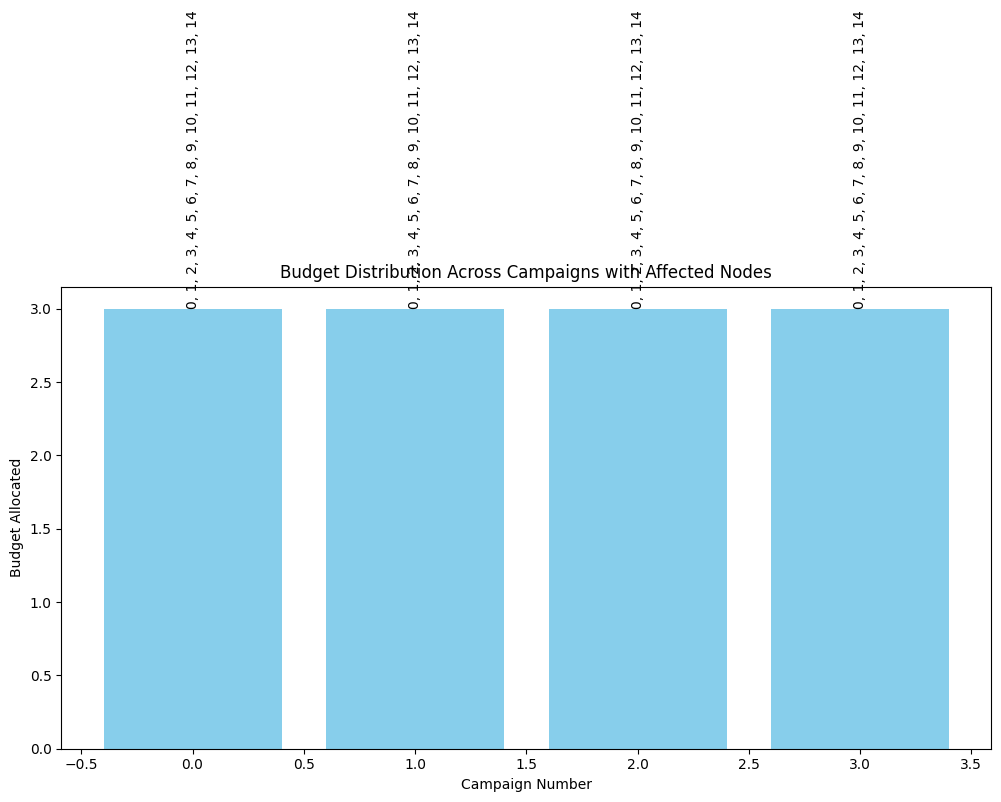

In [ ]:
# Example usage for Brute Force Strategy
env = init_env()
num_steps = 4000  # Total number of steps in the simulation
M = 3  # Number of campaigns
Q = 15  # Total budget
campaign_length = 0.5  # Campaign length in continuous time

# Run the experiment with brute force strategy
opinions_over_time, budget_distribution, affected_nodes = run_experiment(
    env,
    num_steps,
    M,
    Q,
    sample_time=env.tau,
    strategy="brute_force",
    campaign_length=campaign_length,
)

# Compute errors
overall_error = compute_average_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

print(f"Brute Force Strategy - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")

# Plot opinions over time
plot_opinions_over_time(opinions_over_time)

# Plot budget distribution and affected nodes
plot_budget_distribution(budget_distribution, affected_nodes)

Uncontrolled Case - Overall Error: 30965.272396430188
Final Error: 7.73571573387295


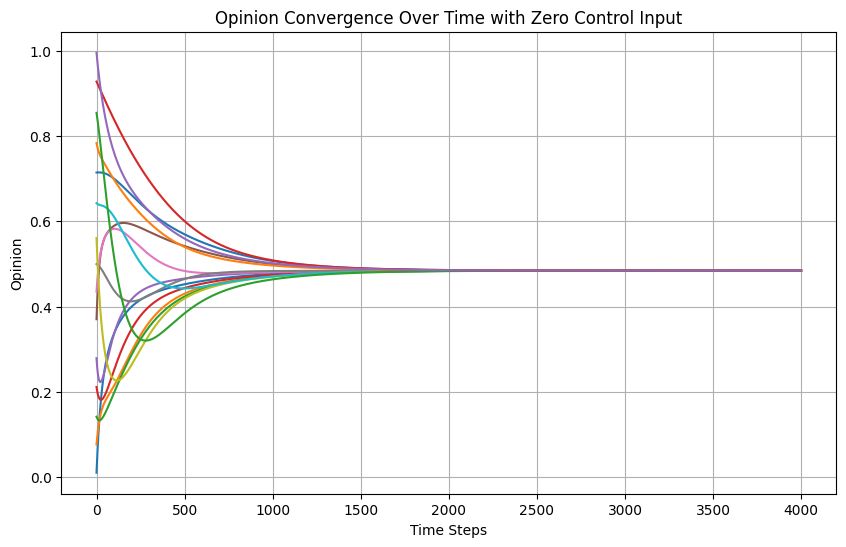

In [ ]:
# Example usage for all strategies
env = init_env()
num_steps = 4000  # Total number of steps in the simulation
M = 3  # Number of campaigns
Q = 15  # Total budget
campaign_length = 0.5  # Time step

# Run the experiment with no control (uncontrolled case)
opinions_over_time_uncontrolled = run_uncontrolled_experiment(env, num_steps)
overall_error_uncontrolled = compute_average_error(
    opinions_over_time_uncontrolled, env.desired_opinion
)
final_error_uncontrolled = compute_final_average_error(
    opinions_over_time_uncontrolled, env.desired_opinion
)

print(f"Uncontrolled Case - Overall Error: {overall_error_uncontrolled}")
print(f"Final Error: {final_error_uncontrolled}")
plot_opinions_over_time(opinions_over_time_uncontrolled)

Broadcast Strategy - Overall Error: 24772.217917144164
Final Error: 6.188572587098369


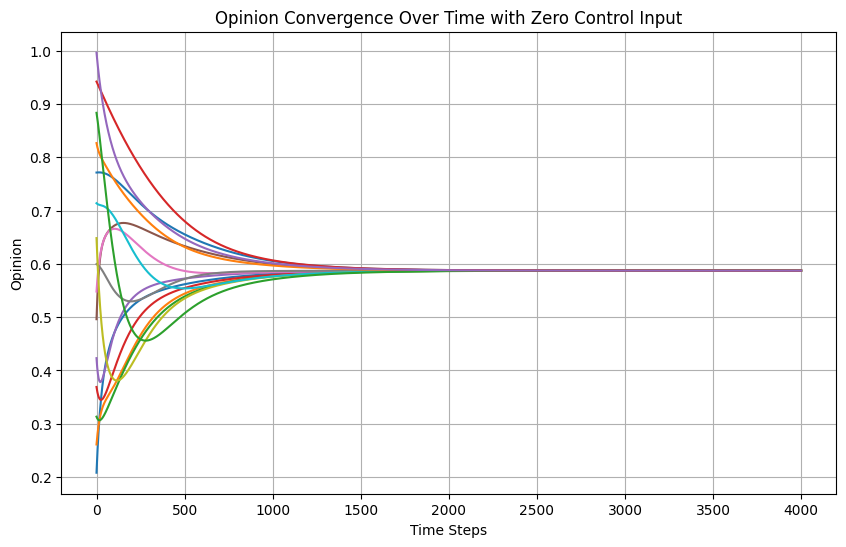

In [ ]:
env = init_env()
num_steps = 4000  # Total number of steps in the simulation
Q = 15  # Total budget
broadcast_duration = 1  # Number of steps to apply the max control input

# Run the experiment with the broadcast strategy
opinions_over_time_broadcast = run_broadcast_strategy(
    env, num_steps, broadcast_duration
)
overall_error_broadcast = compute_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)
final_error_broadcast = compute_final_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time_broadcast)

### Aligning with matlab version

Adjacency Matrix:
 [[0 0 1 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0]]


In [ ]:
connectivity_matrix = np.array(
    [
        # 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # 1
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 2
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 3
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 4
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 5
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # 6
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],  # 7
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 8
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 9
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],  # 10
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0],  # 11
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],  # 12
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 13
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # 14
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # 15
    ]
)

np.array(adjacency_matrix) == connectivity_matrix

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  T